In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [137]:
import sklearn
from sklearn.metrics import accuracy_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

In [276]:
# Import  data
data = pd.read_csv("assessment input.csv", parse_dates=[0])

In [277]:
data.head()

,Time,PLANT,DOSE,A,B,C,D,E,F,G,H,I,J
0,2009-04-28 00:00:00,P04,77.2,5.6,120.0,86,37,7.23,7.8,6.55,17.4,501,3.5
1,2009-04-28 12:00:00,P04,77.2,5.6,120.0,86,37,7.23,7.8,6.55,17.4,501,3.5
2,2009-04-29 00:00:00,P04,77.2,5.6,120.0,86,37,7.23,7.8,6.55,17.9,501,3.5
3,2009-04-29 12:00:00,P04,77.2,5.6,120.0,86,37,7.23,7.8,6.55,18.0,501,3.5
4,2009-04-30 00:00:00,P04,77.2,5.6,120.0,89.5,37,7.23,7.8,6.55,18.0,469.5,3.5


In [107]:
# List unique PLANTs
print(data.PLANT.unique())

['P04' 'P01' 'P05' 'P07' 'P09' 'P03' 'P08' 'P10' 'P06' 'P02']


In [108]:
# Sort data
data = data.sort_values(by=['PLANT','Time'])

In [109]:
# CHECK FOR MISSING VALUES
print(data.isna().sum())

Time     0
PLANT    0
DOSE     0
A        0
B        0
C        0
D        0
E        0
F        0
G        0
H        0
I        0
J        0
dtype: int64


In [110]:
# CHECK FOR NON-NUMERIC VALUES
# define function to convert floats
def converter(x):
    try:
        x = float(x)
        return np.nan
    except ValueError:
        return x
# use list comprehension to apply function and clean up
res = {col: data[col].apply(converter).dropna()\
                   .drop_duplicates().tolist() for col in data.drop('Time',axis=1)}
res

{'PLANT': ['P01',
  'P02',
  'P03',
  'P04',
  'P05',
  'P06',
  'P07',
  'P08',
  'P09',
  'P10'],
 'DOSE': [],
 'A': ['#VALUE!'],
 'B': [],
 'C': ['#VALUE!'],
 'D': ['#VALUE!'],
 'E': [],
 'F': ['#VALUE!'],
 'G': ['#VALUE!'],
 'H': [],
 'I': ['#VALUE!'],
 'J': ['#VALUE!']}

In [111]:
# CHECK NUMBER OF NON-NUMERIC VALUES
print(data.isin(['#VALUE!']).sum())

Time        0
PLANT       0
DOSE        0
A         127
B           0
C           7
D         127
E           0
F         232
G         110
H           0
I        8537
J        8537
dtype: int64


In [112]:
data.groupby(['PLANT']).count()

,Time,DOSE,A,B,C,D,E,F,G,H,I,J
PLANT,,,,,,,,,,,,
P01,5079,5079,5079,5079,5079,5079,5079,5079,5079,5079,5079,5079
P02,61,61,61,61,61,61,61,61,61,61,61,61
P03,4820,4820,4820,4820,4820,4820,4820,4820,4820,4820,4820,4820
P04,5204,5204,5204,5204,5204,5204,5204,5204,5204,5204,5204,5204
P05,5035,5035,5035,5035,5035,5035,5035,5035,5035,5035,5035,5035
P06,4706,4706,4706,4706,4706,4706,4706,4706,4706,4706,4706,4706
P07,5068,5068,5068,5068,5068,5068,5068,5068,5068,5068,5068,5068
P08,4833,4833,4833,4833,4833,4833,4833,4833,4833,4833,4833,4833
P09,5071,5071,5071,5071,5071,5071,5071,5071,5071,5071,5071,5071


PLANT
P01    AxesSubplot(0.125,0.125;0.775x0.755)
P02    AxesSubplot(0.125,0.125;0.775x0.755)
P03    AxesSubplot(0.125,0.125;0.775x0.755)
P04    AxesSubplot(0.125,0.125;0.775x0.755)
P05    AxesSubplot(0.125,0.125;0.775x0.755)
P06    AxesSubplot(0.125,0.125;0.775x0.755)
P07    AxesSubplot(0.125,0.125;0.775x0.755)
P08    AxesSubplot(0.125,0.125;0.775x0.755)
P09    AxesSubplot(0.125,0.125;0.775x0.755)
P10    AxesSubplot(0.125,0.125;0.775x0.755)
Name: DOSE, dtype: object

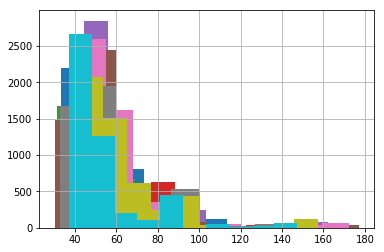

In [114]:
data.groupby('PLANT')['DOSE'].hist()

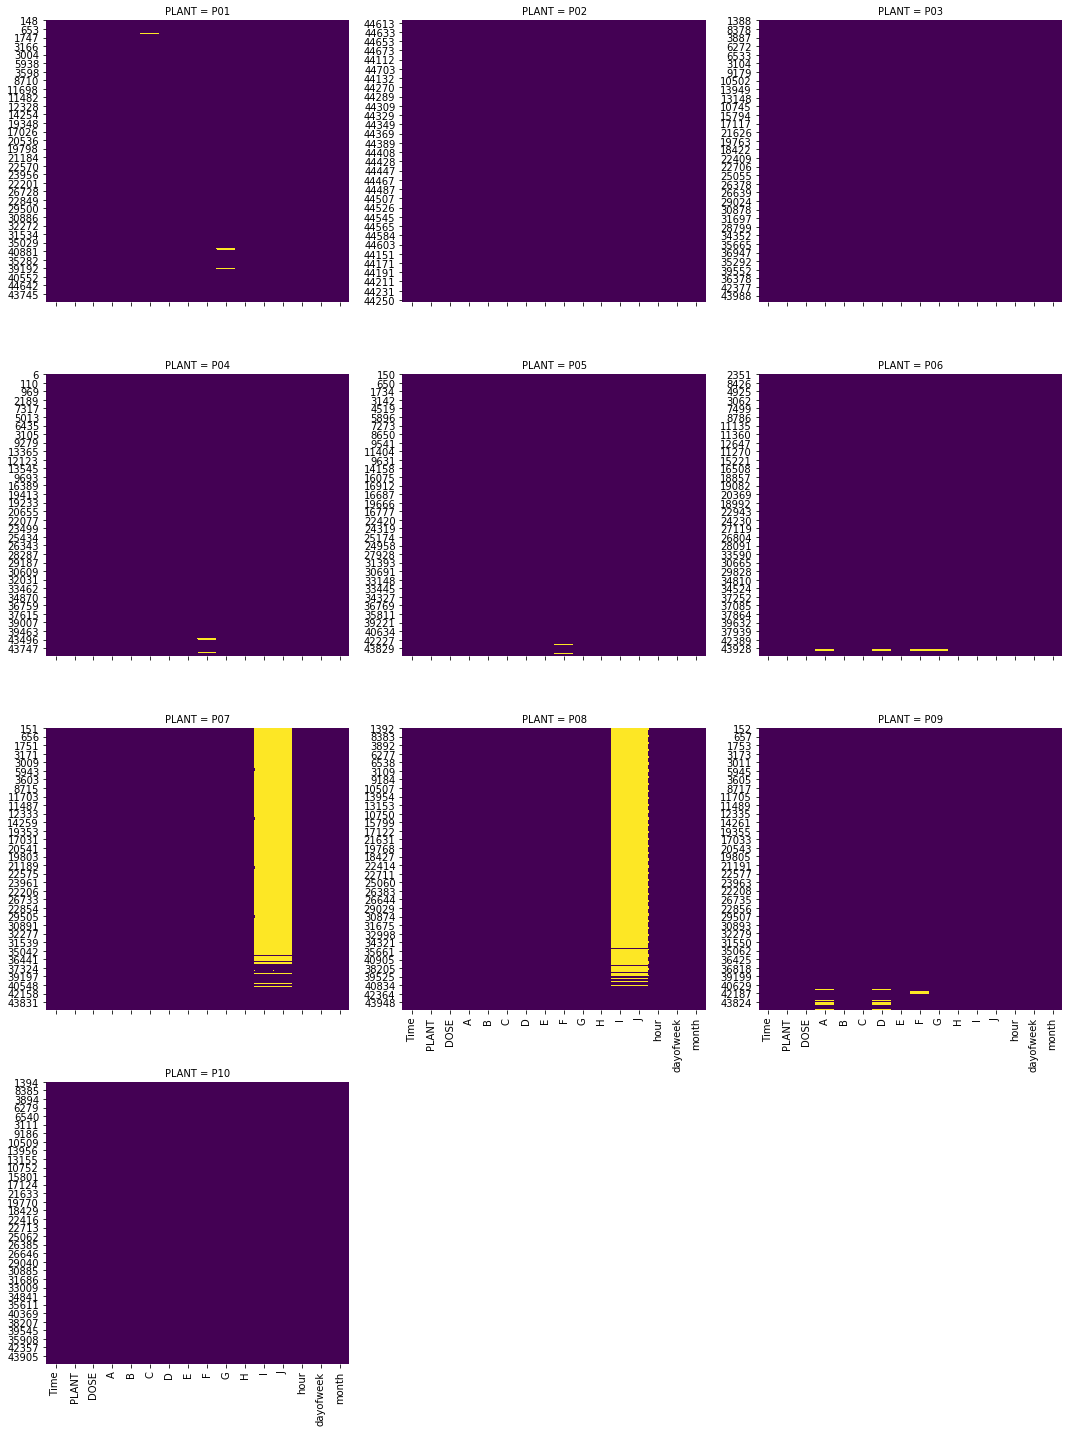

In [213]:
# Check the data for '#VALUE!' using heatmap
def facet_heatmap(data, color, **kws):
    data = data.isin(['#VALUE!'])
    sns.heatmap(data, xticklabels=True, cbar= False, cmap='viridis', **kws)
g = sns.FacetGrid(data, col='PLANT', col_wrap=3, height=5, sharey=False)
g = g.map_dataframe(facet_heatmap)

In [283]:
# Replace invalid data with nulls
data2=data.replace({"#VALUE!": None})

In [284]:
# Verify that '#VALUE!' are now all null
print(data2.isnull().sum())

Time        0
PLANT       0
DOSE        0
A         127
B           0
C           7
D         127
E           0
F         232
G         110
H           0
I        8537
J        8537
dtype: int64


In [294]:
# encode PLANT variables as numbers 
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data2['PLANT_le'] = le.fit_transform(data2['PLANT'])
data2.head()

,Time,PLANT,DOSE,A,B,C,D,E,F,G,H,I,J,hour,dayofweek,month,PLANT_le
0,2009-04-28 00:00:00,P04,77.2,5.6,120.0,86,37,7.23,7.8,6.55,17.4,501,3.5,0,1,4,3
1,2009-04-28 12:00:00,P04,77.2,5.6,120.0,86,37,7.23,7.8,6.55,17.4,501,3.5,12,1,4,3
2,2009-04-29 00:00:00,P04,77.2,5.6,120.0,86,37,7.23,7.8,6.55,17.9,501,3.5,0,2,4,3
3,2009-04-29 12:00:00,P04,77.2,5.6,120.0,86,37,7.23,7.8,6.55,18.0,501,3.5,12,2,4,3
4,2009-04-30 00:00:00,P04,77.2,5.6,120.0,89.5,37,7.23,7.8,6.55,18.0,469.5,3.5,0,3,4,3


In [295]:
# Create time series features from datetime
data2['hour'] = data2['Time'].dt.hour
data2['dayofweek'] = data2['Time'].dt.dayofweek
data2['month'] = data2['Time'].dt.month
data2.head()

,Time,PLANT,DOSE,A,B,C,D,E,F,G,H,I,J,hour,dayofweek,month,PLANT_le
0,2009-04-28 00:00:00,P04,77.2,5.6,120.0,86,37,7.23,7.8,6.55,17.4,501,3.5,0,1,4,3
1,2009-04-28 12:00:00,P04,77.2,5.6,120.0,86,37,7.23,7.8,6.55,17.4,501,3.5,12,1,4,3
2,2009-04-29 00:00:00,P04,77.2,5.6,120.0,86,37,7.23,7.8,6.55,17.9,501,3.5,0,2,4,3
3,2009-04-29 12:00:00,P04,77.2,5.6,120.0,86,37,7.23,7.8,6.55,18.0,501,3.5,12,2,4,3
4,2009-04-30 00:00:00,P04,77.2,5.6,120.0,89.5,37,7.23,7.8,6.55,18.0,469.5,3.5,0,3,4,3


In [296]:
# split into 'main' (every PLANT except P07 and P08), and 'P07_P08' 
data2_main = data2[((data2.PLANT != 'P07') & (data2.PLANT != 'P08'))]
data2_P07_P08 = data2[((data2.PLANT == 'P07') | (data2.PLANT == 'P08'))]

In [297]:
# Impute missing data for all Plants (except P07 and P08) by using previous non-NA value
data2_main = data2_main.fillna(method='ffill')

In [298]:
print(data2_P07_P08.isnull().sum())

Time            0
PLANT           0
DOSE            0
A               0
B               0
C               0
D               0
E               0
F               0
G               0
H               0
I            8537
J            8537
hour            0
dayofweek       0
month           0
PLANT_le        0
dtype: int64


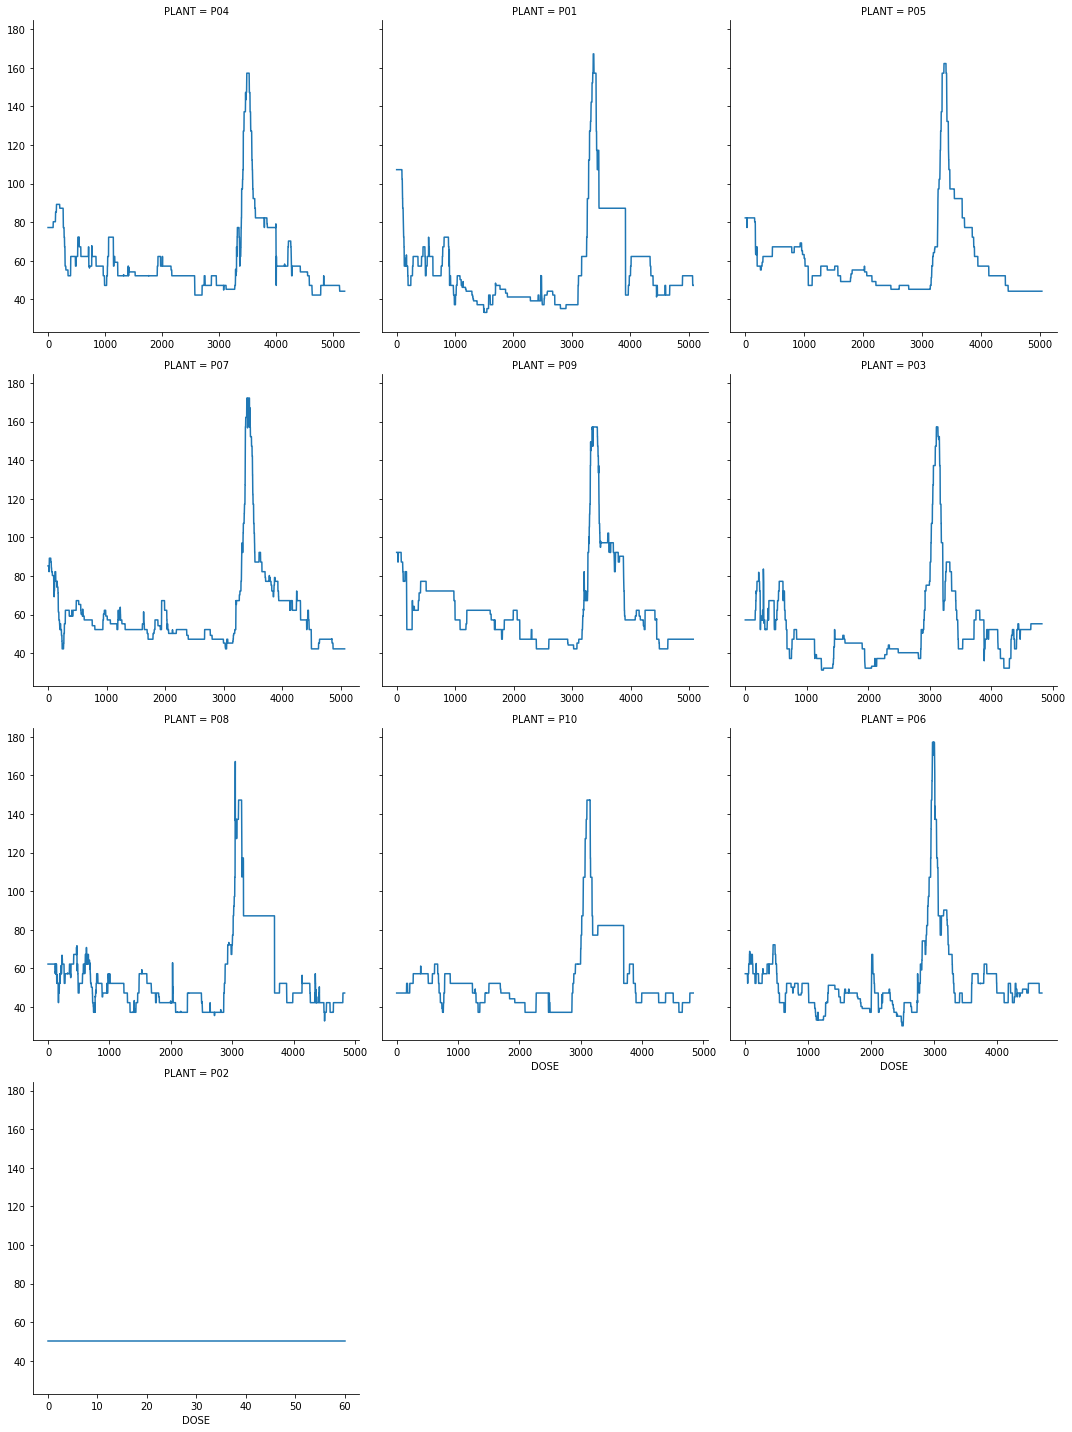

In [392]:
g = sns.FacetGrid(data, col='PLANT', col_wrap=3, height=5, sharex=False)
g = g.map(plt.plot, "DOSE", linestyle='solid', marker='None')

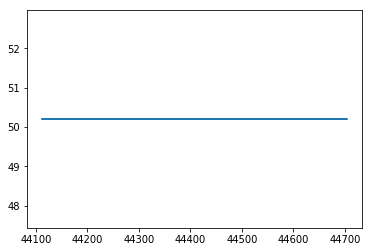

In [102]:
plt.plot(data[data['PLANT']=='P02'].DOSE)

### **Model training and predictions**
- train two models: one for P07 and P08, and another one for the other plants
    - for each of these cases, train a low, medium and high scenario
- for Plant 7 and 8, exclude features I and J

In [323]:
X_main = data2_main.drop(['DOSE','PLANT','Time'], axis=1)
y_main = data2_main['DOSE']
X_P07_P08 = data2_P07_P08.drop(['DOSE','PLANT','Time','I','J'], axis=1)
y_P07_P08 = data2_P07_P08['DOSE']

In [303]:
# Assign the time series method to a variable, with 5 sets
tss = TimeSeriesSplit(n_splits=5)

In [304]:
# Set lower and upper quantile
LOWER_ALPHA = 0.1
UPPER_ALPHA = 0.9

In [305]:
lower_model = GradientBoostingRegressor(loss="quantile", alpha=LOWER_ALPHA)
mid_model = GradientBoostingRegressor(loss="ls")
upper_model = GradientBoostingRegressor(loss="quantile", alpha=UPPER_ALPHA)

In [306]:
# create search grid
param_search = {'max_depth': [3,5]}

In [322]:
# Train model for all Plants (except P07 and P08) for low, middle, and high intervals
gsearch_main_low = GridSearchCV(estimator=lower_model, cv=tss, param_grid=param_search)
gsearch_main_low.fit(X_main,y_main);
gsearch_main_mid = GridSearchCV(estimator=mid_model, cv=tss, param_grid=param_search)
gsearch_main_mid.fit(X_main,y_main);
gsearch_main_high = GridSearchCV(estimator=upper_model, cv=tss, param_grid=param_search)
gsearch_main_high.fit(X_main,y_main);

In [324]:
# Train model for P07 and P08 for low, middle, and high intervals
gsearch_P07_P08_low = GridSearchCV(estimator=lower_model, cv=tss, param_grid=param_search)
gsearch_P07_P08_low.fit(X_P07_P08,y_P07_P08);
gsearch_P07_P08_mid = GridSearchCV(estimator=mid_model, cv=tss, param_grid=param_search)
gsearch_P07_P08_mid.fit(X_P07_P08,y_P07_P08);
gsearch_P07_P08_high = GridSearchCV(estimator=upper_model, cv=tss, param_grid=param_search)
gsearch_P07_P08_high.fit(X_P07_P08,y_P07_P08);

In [388]:
# Calculate the coefficient of determination R^2 of the prediction
gsearch_main_mid.score(X_main, y_main)

0.9092442076523076

In [390]:
# Calculate the coefficient of determination R^2 of the prediction
gsearch_P07_P08_mid.score(X_P07_P08, y_P07_P08)

0.9576923543613758

In [351]:
# Record predictions
predictions_main = pd.DataFrame(y_main)
predictions_main['PRED'] = gsearch_main_mid.predict(X_main)
predictions_main['PRED_HIGH'] = gsearch_main_high.predict(X_main)
predictions_main['PRED_LOW'] = gsearch_main_low.predict(X_main)
predictions_P07_P08 = pd.DataFrame(y_P07_P08)
predictions_P07_P08['PRED'] = gsearch_P07_P08_mid.predict(X_P07_P08)
predictions_P07_P08['PRED_HIGH'] = gsearch_P07_P08_high.predict(X_P07_P08)
predictions_P07_P08['PRED_LOW'] = gsearch_P07_P08_low.predict(X_P07_P08)

In [353]:
# Produce final prediction file
main = pd.concat([data2_main[['Time','PLANT','DOSE']], predictions_main[['PRED','PRED_HIGH','PRED_LOW']]], axis=1)
P07_P08 = pd.concat([data2_P07_P08[['Time','PLANT','DOSE']], predictions_P07_P08[['PRED','PRED_HIGH','PRED_LOW']]], axis=1)
final = pd.concat([main, P07_P08], axis=0)

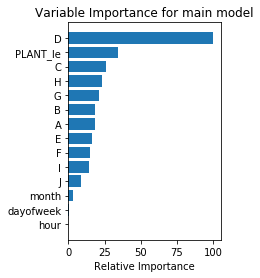

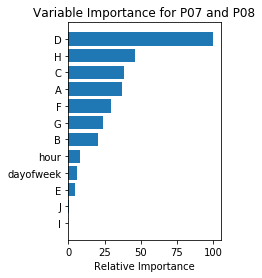

In [380]:
# Plot feature importance
feature_importance = gsearch_main_mid.best_estimator_.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_main.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance for main model')
plt.show()

feature_importance = gsearch_P07_P08_mid.best_estimator_.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_main.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance for P07 and P08')
plt.show()

In [354]:
assessment_result.to_csv('final.csv', index=False)